In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import json
import os
from itertools import cycle
from datetime import datetime
from typing import Iterable

In [2]:
# Setup Color generator
cycol = cycle([
    "blue",
    "green",
    "red",
    "orange",
    "magenta",
    "black"
    ])

In [3]:
# Goal Timestamp Creation
def provide_goal_timestamp(timestamp: Iterable[datetime]) -> Iterable[datetime]:
    return [timestamp[0] + pd.to_timedelta("30 sec")]

In [4]:
# Get actual Smartwatch data in folder
def get_hkquantity_hr_file() -> str:
    for filename in os.listdir("."):
        if filename.startswith("HKQuantityTypeIdentifierHeartRate_"):
            return filename

In [5]:
# Read Metadata
with open("metadata.json", mode="r") as file:
    metadata = json.load(file)

In [6]:
# Liveticker Daten
df_liveticker = pd.read_csv("liveticker.csv")
df_liveticker["timestamp"] = pd.to_datetime(df_liveticker["timestamp"])
df_liveticker = df_liveticker.set_index("timestamp")

In [7]:
# Heartrate Daten
df_heartrate = pd.read_csv(get_hkquantity_hr_file(), skiprows=1)
timestamp = pd.to_datetime(df_heartrate["startDate"])
df_heartrate.insert(0, "timestamp", timestamp)
df_heartrate = df_heartrate.set_index("timestamp")

In [8]:
# Calculate Feature and set limits
df_heartrate = df_heartrate[metadata["start_datetime"] : metadata["end_datetime"]]
rr_interval = 60000 / df_heartrate["value"]
df_heartrate.insert(4, "rr_interval", rr_interval)

In [9]:
# Merge DataFrames
df_merged = pd.merge_asof(
    df_heartrate, df_liveticker,
    left_index=True,
    right_index=True,
    tolerance=pd.to_timedelta("1 min"),
    direction="backward"
    )

In [10]:
# Prepare Plotting
rr_interval = df_merged.rr_interval.values
df_merged.is_goal.replace({
    True: 200,
    False: 0,
    np.nan: 0},
    inplace=True
    )
df_merged.is_card.replace({
    True: 100,
    False: 0,
    np.nan: 0},
    inplace=True
    )
df_merged.halftime.replace({
    1: 100,
    2: 100,
    np.nan: 0},
    inplace=True
    )
liveticker_value = df_merged["is_goal"] + df_merged["is_card"] + df_merged["halftime"]
df_merged["liveticker_value"] = liveticker_value

In [11]:
# Plotting Data
x = df_merged.index.values
x = x.reshape(len(x), 1)
rr_interval = df_merged.rr_interval.values
rr_interval = rr_interval.reshape(len(rr_interval), 1)
liveticker_value = df_merged["liveticker_value"].values
liveticker_value = liveticker_value.reshape(len(liveticker_value), 1)
df_goals = df_liveticker[df_liveticker["is_goal"]]

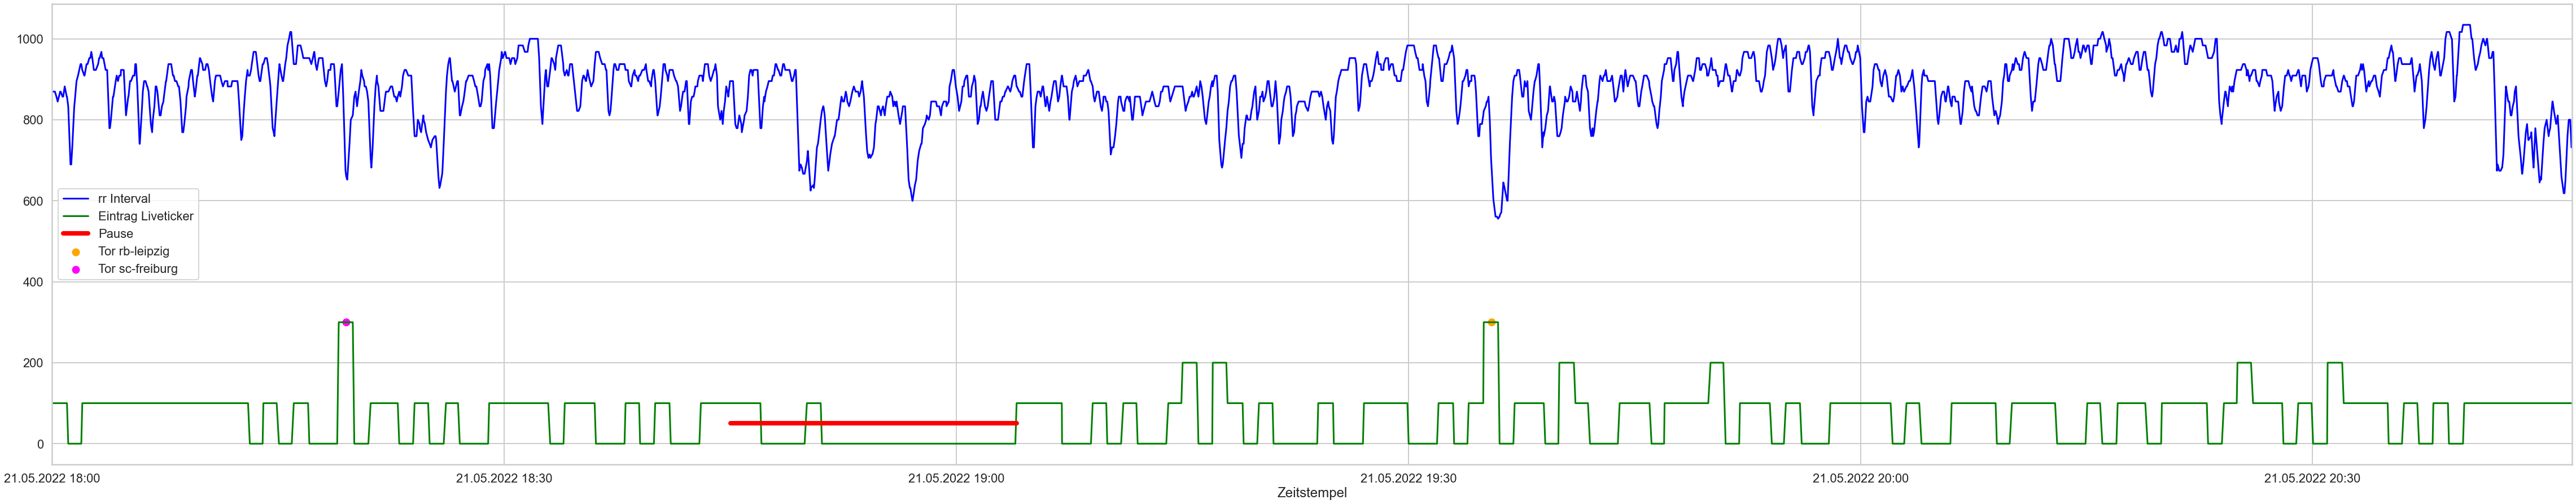

In [12]:
# Final Plotting
# Set Stype
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")
# Plot size
plt.rcParams["figure.figsize"] = (80,15)
# Set axis label
plt.xlabel("Zeitstempel")
# Plot RR Interval
plt.plot(
    x,
    rr_interval,
    c=next(cycol),
    label="rr Interval"
    )
# Plot Liveticker Data
plt.plot(
    x,
    liveticker_value,
    c=next(cycol),
    label="Eintrag Liveticker"
    )
# Plot and Mark Break
plt.plot(
    (pd.to_datetime(metadata["break_start"]),
    pd.to_datetime(metadata["break_end"])),
    (50,50),
    c=next(cycol),
    linewidth=8,
    label="Pause"
    )
# mark team goals
for team in set(metadata["team_shortname_mapping"].values()):
    team_goals = df_goals[df_goals["relevant_team"] == team].index.values
    team_goals = team_goals.reshape(len(team_goals), 1)
    team_goals = list(map(provide_goal_timestamp, team_goals))
    plt.scatter(
        team_goals,
        [300 for _ in range(len(team_goals))],
        c=next(cycol),
        label=f"Tor {team}"
        )
# Axis Settings
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d.%m.%Y %H:%M')
    )
plt.xlim(
    pd.to_datetime(metadata["start_datetime"]),
    pd.to_datetime(metadata["end_datetime"])
    )
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc="center left"
    )
# Plot
plt.show()
